In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

In [6]:
N = 200
phi_a = 6.1 * np.pi
theta_a = 35*np.pi/180
a = 2.
fwhm = 1. * np.pi
i = 45 * np.pi / 180
phi = np.linspace(0, 30*np.pi, N)
qlum = 1e28 * u.erg/u.s
R = .15 * R_sun
median = 500.
phi0= 7 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
              phi=phi, num_pts=50, qlum=qlum,
              Fth=Fth, R=R, median=median)
flare = aflare(phi, phi_a, fwhm, a*median,)

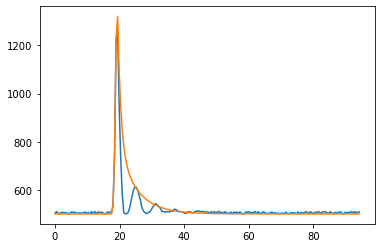

In [7]:

flux = m + np.random.rand(N) * 10.
flux_err = np.full(N, 5.)
plt.plot(phi, flux)
plt.plot(phi, flare+median);

## Define likelihoods

In [8]:
#inclination has an uncertainty from Vsin i measurement, give it a gauss
i_mu, i_sigma = i, .001*i
# the maximum of the flux +/- one period should be right
phi_a_max = phi[-1]


## Run MCMC

In [10]:

inits = np.array([phi_a, theta_a, a, fwhm, i, phi0]) 
pos = inits * (1. + 1e-4 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "phi_a_max":phi_a_max}))
sampler.run_mcmc(pos, 20, progress=True);

100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


In [11]:
theta_a

0.6108652381980153

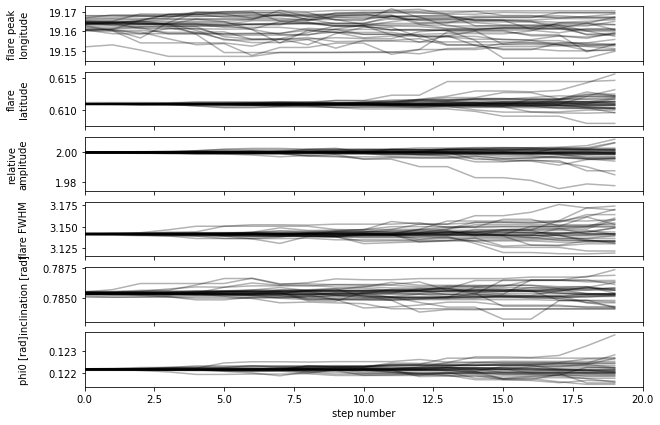

In [12]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['flare peak\nlongitude', 'flare\nlatitude', 'relative\namplitude', 'flare\nFWHM', 'inclination \nrad]', 'phi0\n[rad]']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.savefig("mock_sample_sigi_i.001.png",dpi=300)

(608, 6)


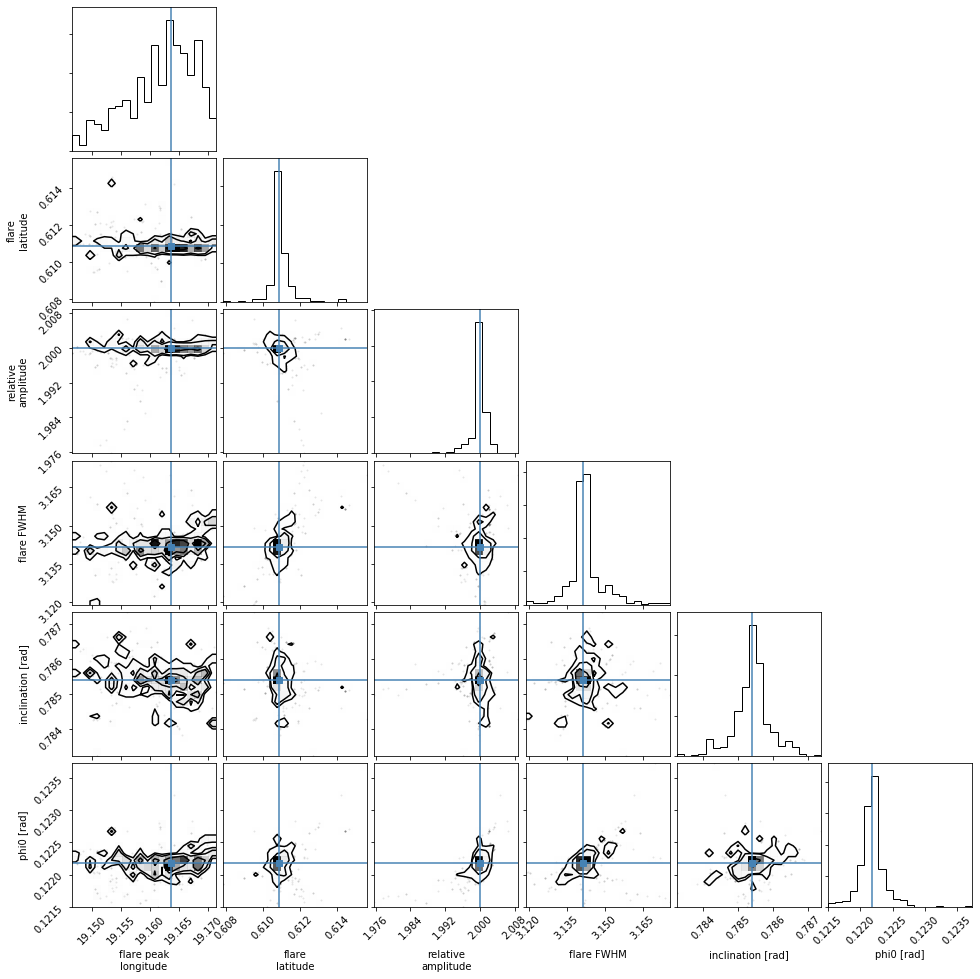

In [13]:

flat_samples = sampler.get_chain(discard=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[phi_a, theta_a, a, fwhm,i, phi0]);
#plt.savefig("corner_mock_sample_sigi_i.001.png",dpi=300)

In [14]:
.61/np.pi*180-.69/np.pi*180 #pm 10

-4.583662361046585

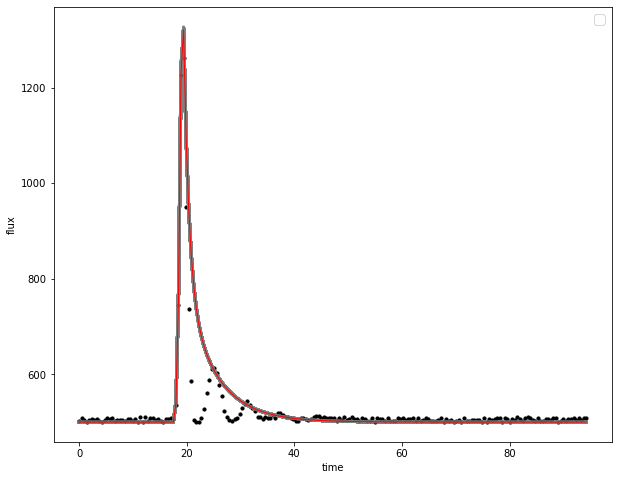

In [15]:
inds = np.random.randint(len(flat_samples), size=1500)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux, s=10, c="k")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a, fwhm, a = sample[[0,3,2]]
    plt.plot(phi, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=14)
plt.xlabel("time")
plt.ylabel("flux");
#plt.savefig("fit_mock_sample_sigi_i.001.png",dpi=300)

In [17]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc, c, d, e = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

((19.161620726246603, 0.005948620692663553, 0.007587185363149729),
 (0.6108986944837884, 0.0007026543475548985, 0.00035116696354420274),
 (1.9999231977726761, 0.002025834648692326, 0.00289471880030967))

In [0]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [0]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [0]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [0]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [0]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [0]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)